In [1]:
import pandas as pd
import spacy
from evaluate import load
import mauve
import nltk
import numpy as np
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request
from nltk import word_tokenize, pos_tag
nlp = spacy.load("en_core_web_sm")

In [2]:
df_generation = pd.read_csv('datasets/Generation_results/df_chat_len.csv')
df_generation

,text,length
0,"The sun sets, casting a golden glow across the...",7
1,"Flowers bloom, adding vibrant colors to the ga...",5
2,"Laughter echoes through the air, filling heart...",10
3,"Gentle raindrops fall, refreshing the earth wi...",8
4,"The moon shines brightly, illuminating the nig...",7
...,...,...
139,"High up in the mountains, where the air was cr...",51
140,"Under the starlit sky, a gentle breeze whisper...",61
141,"In the realm of dreams, where imagination know...",65
142,"As the sun dipped below the horizon, painting ...",70


In [3]:
df_train = pd.read_csv('../230503_ucu_materials/data/train.csv')

In [3]:
def preprocess(sentence):
    doc = nlp(sentence)
    string = ''
    for token in doc:
        string += token.text
        string += ' '
    return string[:-1]

In [4]:
df_generation['text'] = df_generation['text'].apply(preprocess)

# 1. Control metrics

In [212]:
def part_of_speech(sentence):
  pos = []
  doc = nlp(sentence)
  for token in doc:
    pos.append(token.pos_)
  return pos

In [112]:
def preprocess_sent(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [114]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [115]:
def sentiment_analysis(sentence):
    sentence = preprocess_sent(sentence)
    encoded_input = tokenizer(sentence, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores) 
    return np.argmax(scores)

In [198]:
def tense_detect(sentence):
  text = word_tokenize(sentence)
  tagged = pos_tag(text)
    
  verb_tags = ['MD','MDF',
              'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
              'DO','DOD','DOZ',
              'HV','HVG','HVN','HVD','HVZ',
              'VB','VBG','VBN','VBD','VBZ',
              'SH',
              'TO',
              'JJ' # maybe?
              ]
    
  verb_phrase = []
  for item in tagged:
    if item[1] in verb_tags:
        verb_phrase.append(item)
  if (verb_phrase == []):
    return({'Not detected'})

  grammar = r"""
    future:                    {<MD><VB><VBN><VBG>}
    future:                    {<MD><VB><VBG>}
    future:                    {<MD><VB><VBN>}
    past:                      {<VBD><VBN><VBG>}
    present:                   {<VBP|VBZ><VBN><VBG>}
    future:                    {<MD><VB>}
    past:                      {<VBD><VBG>}
    past:                      {<VBD><VBN>}
    present:                   {<VBZ|VBP><VBG>}
    present:                   {<VBZ|VBP><VBN>}
    past:                      {<VBD>}
    present:                   {<VBZ>|<VBP>}
  """

  cp = nltk.RegexpParser(grammar)
  result = cp.parse(verb_phrase)
#  display(result)    
                      
  tenses_set = set()
  for node in result:
    if type(node) is nltk.tree.Tree:
        tenses_set.add(node.label())
  
  return tenses_set

In [247]:
df_generation['pos_check'] = df_generation['text'].apply(part_of_speech)
df_generation['sentiment_check'] = df_generation['text'].apply(sentiment_analysis)
df_generation['tense_check'] = df_generation['text'].apply(tense_detect)
df_generation

,text,pos,sentiment,tense,pos_check,sentiment_check,tense_check
0,It ’s useless .,PRON VERB ADJ PUNCT,negative,present,"[PRON, VERB, ADJ, PUNCT]",0,{present}
1,They had lost their entire expedition .,PRON AUX VERB PRON ADJ NOUN PUNCT,negative,past,"[PRON, AUX, VERB, PRON, ADJ, NOUN, PUNCT]",0,{past}
2,It was painful .,PRON AUX ADJ PUNCT,negative,past,"[PRON, AUX, ADJ, PUNCT]",0,{past}
3,It is painted .,PRON AUX VERB PUNCT,negative,present,"[PRON, AUX, VERB, PUNCT]",1,{present}
4,Based on this will hurt business lending insti...,VERB ADP PRON AUX VERB NOUN VERB NOUN NOUN PUN...,negative,future,"[VERB, ADP, PRON, AUX, VERB, NOUN, NOUN, NOUN,...",0,{future}
...,...,...,...,...,...,...,...
995,"He ’s growing , out of growing to his max .",PRON AUX VERB PUNCT ADP ADP VERB ADP PRON NOUN...,positive,present,"[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,{present}
996,"And despite California ’s drought battling , m...",CCONJ SCONJ PROPN NOUN NOUN VERB PUNCT NOUN AD...,positive,past,"[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",1,{past}
997,From the bench graphs above the reflected valu...,ADP DET NOUN VERB ADP DET VERB NOUN PUNCT ADJ ...,positive,present,"[ADP, DET, NOUN, NOUN, ADP, DET, VERB, NOUN, P...",2,{}
998,Research on self - driving cars shows to the p...,NOUN ADP NOUN PUNCT VERB NOUN VERB ADP DET NOU...,positive,present,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",1,{present}


In [248]:
df_generation['pos'] = df_generation['pos'].apply(lambda row: row.split())
df_generation

,text,pos,sentiment,tense,pos_check,sentiment_check,tense_check
0,It ’s useless .,"[PRON, VERB, ADJ, PUNCT]",negative,present,"[PRON, VERB, ADJ, PUNCT]",0,{present}
1,They had lost their entire expedition .,"[PRON, AUX, VERB, PRON, ADJ, NOUN, PUNCT]",negative,past,"[PRON, AUX, VERB, PRON, ADJ, NOUN, PUNCT]",0,{past}
2,It was painful .,"[PRON, AUX, ADJ, PUNCT]",negative,past,"[PRON, AUX, ADJ, PUNCT]",0,{past}
3,It is painted .,"[PRON, AUX, VERB, PUNCT]",negative,present,"[PRON, AUX, VERB, PUNCT]",1,{present}
4,Based on this will hurt business lending insti...,"[VERB, ADP, PRON, AUX, VERB, NOUN, VERB, NOUN,...",negative,future,"[VERB, ADP, PRON, AUX, VERB, NOUN, NOUN, NOUN,...",0,{future}
...,...,...,...,...,...,...,...
995,"He ’s growing , out of growing to his max .","[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",positive,present,"[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,{present}
996,"And despite California ’s drought battling , m...","[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",positive,past,"[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",1,{past}
997,From the bench graphs above the reflected valu...,"[ADP, DET, NOUN, VERB, ADP, DET, VERB, NOUN, P...",positive,present,"[ADP, DET, NOUN, NOUN, ADP, DET, VERB, NOUN, P...",2,{}
998,Research on self - driving cars shows to the p...,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",positive,present,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",1,{present}


In [249]:
df_generation['sentiment'] = df_generation['sentiment'].replace('positive', 2)
df_generation['sentiment'] = df_generation['sentiment'].replace('neutral', 1)
df_generation['sentiment'] = df_generation['sentiment'].replace('negative', 0)
df_generation

,text,pos,sentiment,tense,pos_check,sentiment_check,tense_check
0,It ’s useless .,"[PRON, VERB, ADJ, PUNCT]",0,present,"[PRON, VERB, ADJ, PUNCT]",0,{present}
1,They had lost their entire expedition .,"[PRON, AUX, VERB, PRON, ADJ, NOUN, PUNCT]",0,past,"[PRON, AUX, VERB, PRON, ADJ, NOUN, PUNCT]",0,{past}
2,It was painful .,"[PRON, AUX, ADJ, PUNCT]",0,past,"[PRON, AUX, ADJ, PUNCT]",0,{past}
3,It is painted .,"[PRON, AUX, VERB, PUNCT]",0,present,"[PRON, AUX, VERB, PUNCT]",1,{present}
4,Based on this will hurt business lending insti...,"[VERB, ADP, PRON, AUX, VERB, NOUN, VERB, NOUN,...",0,future,"[VERB, ADP, PRON, AUX, VERB, NOUN, NOUN, NOUN,...",0,{future}
...,...,...,...,...,...,...,...
995,"He ’s growing , out of growing to his max .","[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,present,"[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,{present}
996,"And despite California ’s drought battling , m...","[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",2,past,"[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",1,{past}
997,From the bench graphs above the reflected valu...,"[ADP, DET, NOUN, VERB, ADP, DET, VERB, NOUN, P...",2,present,"[ADP, DET, NOUN, NOUN, ADP, DET, VERB, NOUN, P...",2,{}
998,Research on self - driving cars shows to the p...,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",2,present,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",1,{present}


In [250]:
df_generation['lentense'] = df_generation['tense_check'].apply(len)
df_generation.loc[df_generation['tense_check'] == {'Not detected'}, 'lentense'] = 0

In [12]:
def length_exact(df):
    expected_length_indexes = df.apply(lambda row: (len(row['text'].split(' ')) == row['length']), axis=1)
    return sum(expected_length_indexes)/len(df)

In [13]:
def length_approximate(df):
    expected_length_indexes = df.apply(lambda row: ((len(row['text'].split(' ')) <= row['length'] + 3) & (len(row['text'].split(' ')) >= row['length'] - 3)), axis=1)
    return sum(expected_length_indexes)/len(df)

In [215]:
def pos_exact(df):
    expected_pos_indexes = df.apply(lambda row: (row['pos'] == row['pos_check']), axis=1)
    return sum(expected_pos_indexes)/len(df)

In [216]:
def pos_unique_without_order(df):
    pos_unigrams_match = df.apply(lambda row: (len(set(row['pos']) & set(row['pos_check']))/len(set(row['pos']))), axis=1)
    return pos_unigrams_match.mean()

In [217]:
def bigrams(l1, l2):
    number_bigrams = 0
    bigrams_l2 =[]
    for j in range(len(l2) - 1):
        bigrams_l2.append([l2[j], l2[j + 1]])
    for i in range(len(l1) - 1):
        sublist = [l1[i], l1[i + 1]]
        if sublist in bigrams_l2: number_bigrams += 1
    return number_bigrams/(len(l1) - 1)

In [218]:
def trigrams(l1, l2):
    number_trigrams = 0
    trigrams_l2 =[]
    for j in range(len(l2) - 2):
        trigrams_l2.append([l2[j], l2[j + 1], l2[j + 2]])
    for i in range(len(l1) - 2):
        sublist = [l1[i], l1[i + 1], l1[i + 2]]
        if sublist in trigrams_l2: number_trigrams += 1
    return number_trigrams/(len(l1) - 2)

In [219]:
def pos_bigrams(df):
    pos_bigrams_match = df.apply(lambda row: bigrams(row['pos'], row['pos_check']), axis=1)
    return pos_bigrams_match.mean()

In [220]:
def pos_trigrams(df):
    pos_trigrams_match = df.apply(lambda row: trigrams(row['pos'], row['pos_check']), axis=1)
    return pos_trigrams_match.mean()

In [2]:
def needleman_wunsch(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-1):
    """
    Very simple aligning algorithm.
    """

    m, n = len(seq1), len(seq2)
    score_matrix = np.zeros((m + 1, n + 1), dtype=int)

    for i in range(m + 1):
        score_matrix[i, 0] = i * gap_penalty
    for j in range(n + 1):
        score_matrix[0, j] = j * gap_penalty

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score_matrix[i - 1, j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_score)
            delete = score_matrix[i - 1, j] + gap_penalty
            insert = score_matrix[i, j - 1] + gap_penalty
            score_matrix[i, j] = max(match, delete, insert)

    aligned_seq1 = []
    aligned_seq2 = []
    i, j = m, n

    while i > 0 or j > 0:
        if i > 0 and j > 0 and score_matrix[i, j] == score_matrix[i - 1, j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_score):
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append(seq2[j - 1])
            i -= 1
            j -= 1
        elif i > 0 and score_matrix[i, j] == score_matrix[i - 1, j] + gap_penalty:
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append('-')
            i -= 1
        else:
            aligned_seq1.append('-')
            aligned_seq2.append(seq2[j - 1])
            j -= 1

    aligned_seq1 = list(reversed(aligned_seq1))
    aligned_seq2 = list(reversed(aligned_seq2))

    return aligned_seq1, aligned_seq2

In [3]:
def pos_alignment(df):
    matches = []
    for i in range(len(df)):
        aligned_input, aligned_pred = needleman_wunsch(df['pos'][i], df['pos_check'][i])
        matches += [g == p for g,p in zip(aligned_input, aligned_pred)]
    return np.mean(matches)

In [6]:
sequence_1 = ['PRON', 'VERB', 'ADJ', 'PUNCT']
sequence_2 = ['PRON', 'AUX', 'VERB', 'PUNCT']
print(needleman_wunsch(sequence_1, sequence_2)[0])
print(needleman_wunsch(sequence_1, sequence_2)[1])

['PRON', '-', 'VERB', 'ADJ', 'PUNCT']
['PRON', 'AUX', 'VERB', '-', 'PUNCT']


In [10]:
aligned_input, aligned_pred = needleman_wunsch(sequence_1, sequence_2)
np.mean([g == p for g,p in zip(aligned_input, aligned_pred)])

0.6

In [1]:
def sentiment_exact(df):
    expected_sentiment_indexes = df.apply(lambda row: (row['sentiment'] == row['sentiment_check']), axis=1)
    return sum(expected_sentiment_indexes)/len(df)

In [181]:
def sentiment_approximate(df):
    expected_sentiment_indexes = df.apply(lambda row: (abs(row['sentiment'] - row['sentiment_check']) <= 1), axis=1)
    return sum(expected_sentiment_indexes)/len(df)

In [201]:
def tense_exact(df):
    expected_tense_indexes = df.apply(lambda row: (row['tense'] in row['tense_check']), axis=1)
    return sum(expected_tense_indexes)/len(df)

In [77]:
length_exact(df_generation)

0.09722222222222222

In [78]:
length_approximate(df_generation)

0.5833333333333334

In [103]:
len(df_generation[(df_generation['length'] >= 71) & (df_generation['length'] <= 80)])

1

In [104]:
length_exact(df_generation[(df_generation['length'] >= 71) & (df_generation['length'] <= 80)])

0.0

In [105]:
length_approximate(df_generation[(df_generation['length'] >= 71) & (df_generation['length'] <= 80)])

0.0

In [252]:
pos_exact(df_generation)

0.409

In [251]:
pos_unique_without_order(df_generation)

0.9739657814407808

In [253]:
pos_bigrams(df_generation)

0.9208244288884342

In [254]:
pos_trigrams(df_generation)

0.8624456179935579

In [255]:
pos_alignment(df_generation)

0.9263997033741194

In [264]:
df_generation[df_generation['sentiment'] == 2]

,text,pos,sentiment,tense,pos_check,sentiment_check,tense_check,lentense
667,You can also enable Harmony to train your Imam...,"[PRON, AUX, ADV, VERB, PROPN, PART, VERB, PRON...",2,future,"[PRON, AUX, ADV, VERB, PROPN, PART, VERB, PRON...",1,{future},1
668,But on the flight of the trade - off was a suc...,"[CCONJ, ADP, DET, NOUN, ADP, DET, NOUN, PUNCT,...",2,past,"[CCONJ, ADP, DET, NOUN, ADP, DET, NOUN, PUNCT,...",2,{past},1
669,When the Eastern States wins and then loses mo...,"[SCONJ, DET, PROPN, PROPN, VERB, CCONJ, ADV, V...",2,present,"[SCONJ, DET, PROPN, PROPN, VERB, CCONJ, ADV, V...",1,{present},1
670,At 8:30 a.m. the UFC Fight Night begins previe...,"[ADP, NUM, DET, PROPN, PROPN, PROPN, VERB, VER...",2,future,"[ADP, NUM, NOUN, DET, PROPN, PROPN, PROPN, VER...",1,{present},1
671,That 'd be slightly more fun .,"[PRON, AUX, PART, ADV, ADJ, NOUN, PUNCT]",2,future,"[PRON, AUX, AUX, ADV, ADJ, NOUN, PUNCT]",2,{future},1
...,...,...,...,...,...,...,...,...
995,"He ’s growing , out of growing to his max .","[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,present,"[PRON, AUX, VERB, PUNCT, ADP, ADP, VERB, ADP, ...",2,{present},1
996,"And despite California ’s drought battling , m...","[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",2,past,"[CCONJ, SCONJ, PROPN, NOUN, NOUN, VERB, PUNCT,...",1,{past},1
997,From the bench graphs above the reflected valu...,"[ADP, DET, NOUN, VERB, ADP, DET, VERB, NOUN, P...",2,present,"[ADP, DET, NOUN, NOUN, ADP, DET, VERB, NOUN, P...",2,{},0
998,Research on self - driving cars shows to the p...,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",2,present,"[NOUN, ADP, NOUN, PUNCT, VERB, NOUN, VERB, ADP...",1,{present},1


In [265]:
sentiment_exact(df_generation[df_generation['sentiment'] == 2])

0.47147147147147145

In [266]:
sentiment_approximate(df_generation[df_generation['sentiment'] == 2])

0.9459459459459459

In [273]:
df_generation[(df_generation['lentense'] > 0) & (df_generation['tense'] == 'future')]

,text,pos,sentiment,tense,pos_check,sentiment_check,tense_check,lentense
4,Based on this will hurt business lending insti...,"[VERB, ADP, PRON, AUX, VERB, NOUN, VERB, NOUN,...",0,future,"[VERB, ADP, PRON, AUX, VERB, NOUN, NOUN, NOUN,...",0,{future},1
5,You must hate that .,"[PRON, AUX, VERB, PRON, PUNCT]",0,future,"[PRON, AUX, VERB, PRON, PUNCT]",0,{future},1
6,They will refuse the plan to give up .,"[PRON, AUX, VERB, DET, NOUN, PART, VERB, ADP, ...",0,future,"[PRON, AUX, VERB, DET, NOUN, PART, VERB, ADP, ...",0,{future},1
8,You will now miss .,"[PRON, AUX, ADV, ADJ, PUNCT]",0,future,"[PRON, AUX, ADV, VERB, PUNCT]",1,{future},1
9,It ’s pretty boring .,"[PRON, VERB, ADV, ADJ, PUNCT]",0,future,"[PRON, VERB, ADV, ADJ, PUNCT]",0,{present},1
...,...,...,...,...,...,...,...,...
975,But I ca n’t wait to be a singing partner to “...,"[CCONJ, PRON, AUX, PROPN, VERB, PART, AUX, DET...",2,future,"[CCONJ, PRON, AUX, NOUN, VERB, PART, AUX, DET,...",2,{future},1
982,"For the first time and in the US , for revenue...","[ADP, DET, ADJ, NOUN, CCONJ, ADP, DET, PROPN, ...",2,future,"[ADP, DET, ADJ, NOUN, CCONJ, ADP, DET, PROPN, ...",1,{present},1
985,We are being funded right this way with whatev...,"[PRON, AUX, AUX, VERB, ADV, DET, NOUN, ADP, PR...",2,future,"[PRON, AUX, AUX, VERB, ADV, DET, NOUN, ADP, PR...",1,{future},1
986,"In his role , President Obama won the Democrat...","[ADP, PRON, NOUN, PUNCT, PROPN, PROPN, VERB, D...",2,future,"[ADP, PRON, NOUN, PUNCT, PROPN, PROPN, VERB, D...",2,{past},1


In [274]:
tense_exact(df_generation[(df_generation['lentense'] > 0) & (df_generation['tense'] == 'future')])

0.7914893617021277

# 2. Fluency metrics

In [5]:
perplexity = load("perplexity", module_type="metric")

In [12]:
def perpl(df):
    perplexities = perplexity.compute(predictions=df['text'].values.tolist(), model_id='gpt2', device='cpu')
    df['perplexity'] = perplexities['perplexities']
    return perplexities['mean_perplexity']

In [13]:
perpl(df_generation)

Using pad_token, but it is not set yet.


  0%|          | 0/9 [00:00<?, ?it/s]

78.09138695398967

In [14]:
df_generation

,text,length,perplexity
0,"The sun sets , casting a golden glow across th...",7,123.059952
1,"Flowers bloom , adding vibrant colors to the g...",5,137.638031
2,"Laughter echoes through the air , filling hear...",10,125.766365
3,"Gentle raindrops fall , refreshing the earth w...",8,174.783737
4,"The moon shines brightly , illuminating the ni...",7,42.624065
...,...,...,...
139,"High up in the mountains , where the air was c...",51,31.506687
140,"Under the starlit sky , a gentle breeze whispe...",61,47.097542
141,"In the realm of dreams , where imagination kno...",65,31.966364
142,"As the sun dipped below the horizon , painting...",70,33.794868


<AxesSubplot:>

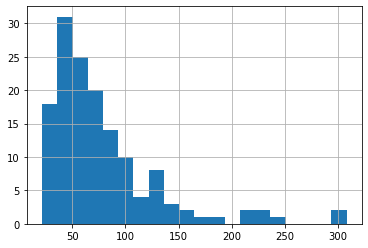

In [15]:
df_generation[df_generation['perplexity'] < 1000]['perplexity'].hist(bins = 20)

In [16]:
df_generation[df_generation['perplexity'] > 1000]

,text,length,perplexity


In [114]:
df_mauve_compare = pd.read_csv('../230503_ucu_materials/data/val.csv')
# df_mauve_compare['pos'] = df_mauve_compare.apply(lambda row: eval(row['pos']), axis=1)
df_mauve_compare

,text,words,pos,sentiment,tense
0,"X can use any attack , Poké - Power , or Poké ...",19,NOUN AUX VERB DET NOUN PUNCT PROPN PUNCT PROPN...,neutral,future
1,There were periods when everything was more op...,14,PRON VERB NOUN SCONJ PRON AUX ADV ADJ PUNCT CC...,neutral,past
2,Trans people are terrified of what lies ahead .,9,PROPN NOUN AUX VERB ADP PRON VERB ADV PUNCT,negative,present
3,Another Global horror is The Cube in Birmingha...,23,DET ADJ NOUN AUX DET PROPN ADP PROPN PUNCT DET...,negative,present
4,The innovative one piece stainless steel shiel...,26,DET ADJ NUM NOUN ADJ NOUN VERB NOUN ADP PROPN ...,positive,present
...,...,...,...,...,...
11027,The application of Dye Solar Cells ( DSC 's ) ...,38,DET NOUN ADP PROPN PROPN PROPN PUNCT PROPN PAR...,positive,present
11028,Along with the majority of Canadians elsewhere...,22,ADP ADP DET NOUN ADP PROPN ADV PUNCT PROPN VER...,neutral,past
11029,"IBM , like other established tech companies , ...",33,PROPN PUNCT ADP ADJ VERB NOUN NOUN PUNCT VERB ...,positive,past
11030,Valuation movements ( think potential falls ) ...,23,NOUN NOUN PUNCT VERB ADJ NOUN PUNCT AUX NOUN V...,neutral,future


In [36]:
def compute_mauve(human_df, generated_df):
    if len(generated_df) > 5000: num_buckets = 500
    else: num_buckets = 'auto'
    return mauve.compute_mauve(p_text=human_df['text'].values.tolist(), q_text=generated_df['text'].values.tolist(), device_id=0, max_text_length=256, verbose=True, num_buckets=num_buckets)

In [ ]:
compute_mauve(df_mauve_compare, df_generation).mauve

Loading tokenizer
Tokenizing text...
Loading tokenizer
Loading model


# 3. Distinctivness metrics

In [20]:
def distinct_ngrams_in_sentence(df, n):
    distinct_ngrams = []
    for i in range(len(df)):
        ngrams = list(nltk.ngrams(df['text'][i].split(), n))
        unique_ngrams = set(ngrams)
        if len(ngrams) > 0: distinct_ngrams.append(len(unique_ngrams)/len(ngrams))
    return np.mean(distinct_ngrams)

In [21]:
distinct_ngrams_in_sentence(df_generation, 1)

0.8974394395231285

In [22]:
distinct_ngrams_in_sentence(df_generation, 2)

0.9975221790341818

In [23]:
distinct_ngrams_in_sentence(df_generation, 3)

1.0

In [24]:
def distinct_ngrams_in_all_sentences(df, n):
    ngrams = []
    for i in range(len(df)):
        ngrams += list(nltk.ngrams(df['text'][i].split(), n))
    unique_ngrams = set(ngrams)
    return len(unique_ngrams)/len(ngrams)

In [25]:
distinct_ngrams_in_all_sentences(df_generation, 1)

0.2853423587607394

In [26]:
distinct_ngrams_in_all_sentences(df_generation, 2)

0.6913713822017852

In [27]:
distinct_ngrams_in_all_sentences(df_generation, 3)

0.880101322825781

In [28]:
def distinct_endings(df, n):
    sentence_endings = []
    for i in range(len(df)):
        sentence_endings.append(str(list(nltk.ngrams(df['text'][i].split(), 1))[-n:]))
    unique_endings = set(sentence_endings)
    return len(unique_endings)/len(sentence_endings)

In [29]:
distinct_endings(df_generation, 2)

0.8125

In [30]:
distinct_endings(df_generation, 3)

0.9166666666666666

In [31]:
def distinct_beginnings(df, n):
    sentence_beginnings = []
    for i in range(len(df)):
        sentence_beginnings.append(str(list(nltk.ngrams(df['text'][i].split(), 1))[:n]))
    unique_beginnings = set(sentence_beginnings)
    return len(unique_beginnings)/len(sentence_beginnings)

In [32]:
distinct_beginnings(df_generation, 2)

0.6805555555555556

In [33]:
distinct_beginnings(df_generation, 3)

0.8680555555555556

In [63]:
def distinct_ngrams_for_repeated_pos(df, n):
    ngrams_df = []
    i = 0
    while i < len(df):
        ngrams = []
        for j in range(5):
            ngrams += list(nltk.ngrams(df['text'][i + j].split(), n))
        unique_ngrams = set(ngrams)
        i += 5
        ngrams_df.append(len(unique_ngrams)/len(ngrams))
    return np.mean(ngrams_df)

In [66]:
distinct_ngrams_for_repeated_pos(df_generation, 2)

0.9170178537943243

In [64]:
distinct_ngrams_for_repeated_pos(df_generation, 3)

0.9735648592419011

In [65]:
distinct_ngrams_for_repeated_pos(df_generation, 5)

0.9939346350205104

In [79]:
def distinct_endings_for_repeated_pos(df, n):
    df_endings = []
    i = 0
    while i < len(df):
        sentence_endings = []
        for j in range(5):
            sentence_endings.append(str(list(nltk.ngrams(df['text'][i + j].split(), 1))[-n:]))
        unique_endings = set(sentence_endings)
        i += 5
        df_endings.append(len(unique_endings)/len(sentence_endings))
    return np.mean(df_endings)

In [80]:
distinct_endings_for_repeated_pos(df_generation, 2)

0.91

In [81]:
distinct_endings_for_repeated_pos(df_generation, 3)

0.9819999999999999

In [88]:
def distinct_beginnings_for_repeated_pos(df, n):
    df_beginnings = []
    i = 0
    while i < len(df):
        sentence_beginnings = []
        for j in range(5):
            sentence_beginnings.append(str(list(nltk.ngrams(df['text'][i + j].split(), 1))[:n]))
        unique_beginnings = set(sentence_beginnings)
        i += 5
        df_beginnings.append(len(unique_beginnings)/len(sentence_beginnings))
    return np.mean(df_beginnings)

In [89]:
distinct_beginnings_for_repeated_pos(df_generation, 2)

0.9

In [90]:
distinct_beginnings_for_repeated_pos(df_generation, 3)

0.961

# 4. Repetition metrics

In [31]:
def distinct_ngrams_repetition(df, df_train, n):
    ngrams = []
    for i in range(len(df)):
        ngrams += list(nltk.ngrams(df['text'][i].split(), n))
    ngrams_train = []
    for i in range(len(df_train)):
        ngrams_train += list(nltk.ngrams(df_train['text'][i].split(), n))
    ngrams_rep = [x for x in ngrams if x in ngrams_train]
    return 1-len(ngrams_rep)/len(ngrams)

In [32]:
distinct_ngrams_repetition(df_generation, df_train, 3)

0.5627926120286053

In [33]:
distinct_ngrams_repetition(df_generation, df_train, 5)

0.962665596146126